In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.image as mpimg

### Validate Data Path

In [2]:
cwd = os.getcwd()

## Place the data in Food-11 directory
data_in_dir = os.path.join(cwd, "Food-11")
assert(os.path.isdir(data_in_dir))

subdirs = {
    'train' : 'training',
    'valid' : 'validation',
    'eval'  : 'evaluation'}
dirs = os.listdir(data_in_dir)

## Validate we have these 3 subdirectories
assert(len(dirs) == len(subdirs) and sorted(dirs) == sorted(subdirs.values()))
   
## Validate that we have the sored data from EDA in pickle format
pickle_dir = os.path.join(cwd, "food-classification-pickle_data")
assert(os.path.isdir(pickle_dir))
data_files = os.listdir(pickle_dir)
data_files
datastore_files = {
    'train' : 'training.pickle',
    'valid' : 'validation.pickle',
    'eval'  : 'evaluation.pickle'}
## Validate we have these 3 datafiles
assert(len(data_files) == len(datastore_files) and sorted(data_files) == sorted(datastore_files.values()))

### Read data from pickle file to dataframes

In [3]:
train_data = pd.read_pickle(os.path.join(pickle_dir, datastore_files['train']))
val_data = pd.read_pickle(os.path.join(pickle_dir, datastore_files['valid']))
eval_data = pd.read_pickle(os.path.join(pickle_dir, datastore_files['eval']))

In [4]:
print(train_data.shape)
print(val_data.shape)
print(eval_data.shape)

(9866, 2)
(3430, 2)
(3347, 2)


### One Hot Encoding Helper Function

In [5]:
MAX_LABELS = len(train_data.Label.unique())

def onehotencoder(label_out):
    batch_size = len(label_out)
    encoded = np.zeros((batch_size, MAX_LABELS))
    encoded[np.arange(batch_size), label_out] = 1
    return encoded

##  Define GET Batch Helper Function

In [6]:
def getbatch(data_in, batchsize=32):
    arraylength = len (data_in);
    count = 0 
    while count < arraylength/batchsize:
        randindex = random.sample(range(0, arraylength), batchsize)
        count += 1
        image_path_out = [data_in.Path[i] for i in randindex]
        label_out = [data_in.Label[i] for i in randindex]
        one_hot_encoded_label_out = onehotencoder(label_out)
        yield (image_path_out, one_hot_encoded_label_out)

## --Augment Data NEGATIVE Helper Function¶

https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35

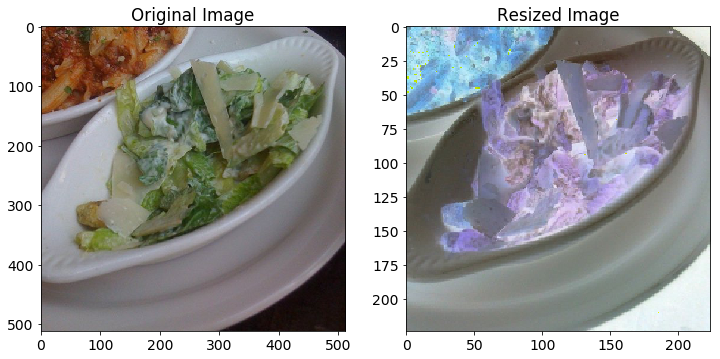

In [28]:
import matplotlib
import matplotlib.pyplot as plt
IMAGE_SIZE = 224
%matplotlib inline

def tf_resize_images(X_img_file_paths, size=IMAGE_SIZE):
    X_data = []
    #tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (size, size), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

X_img_paths, Y_Labels = next(getbatch(train_data))
X_imgs = tf_resize_images(X_img_paths)

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(X_img_paths[4])[:,:,:3])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_imgs[4])
plt.title('Resized Image')
plt.show()

## Dump the dataframe to file to feed it into Alexnet

In [9]:
# Path to the textfiles for the trainings and validation set
train_file = 'train.txt'
val_file = 'valid.txt'
eval_file = 'eval.txt'
train_data.to_csv(train_file, sep=" ", header=False, index=False)
val_data.to_csv(val_file, sep=" ", header=False, index=False)
eval_data.to_csv(eval_file, sep=" ", header=False, index=False)

# Alexnet Training
Author: Frederik Kratzert
contact: f.kratzert(at)gmail.com

In [10]:
from alexnet import AlexNet
from datagenerator import ImageDataGenerator
from datetime import datetime
from tensorflow.contrib.data import Iterator

### Hyper Parameters

In [11]:
# Learning params
learning_rate = 0.005
num_epochs = 1
batch_size = 128

# Network params
dropout_rate = 0.5
num_classes = 11

# How often we want to write the tf.summary data to disk
display_step = 20

## Output directory for tensorboard and session weights

In [12]:
# Path for tf.summary.FileWriter and to store model checkpoints
filewriter_path = "tensorboard"
checkpoint_path = "checkpoints"
# Create parent path if it doesn't exist
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)
# Create parent path if it doesn't exist
if not os.path.isdir(filewriter_path):
    os.mkdir(filewriter_path)

## Load data onto CPU and get iterators

In [29]:
# Place data loading and preprocessing on the cpu
with tf.device('/cpu:0'):
    tr_data = ImageDataGenerator(train_file,
                                 mode='training',
                                 batch_size=batch_size,
                                 num_classes=num_classes,
                                 shuffle=True)
    val_data = ImageDataGenerator(val_file,
                                  mode='inference',
                                  batch_size=batch_size,
                                  num_classes=num_classes,
                                  shuffle=False)

    # create an reinitializable iterator given the dataset structure
    iterator = Iterator.from_structure(tr_data.data.output_types,
                                       tr_data.data.output_shapes)
    next_batch = iterator.get_next()

# Ops for initializing the two different iterators
training_init_op = iterator.make_initializer(tr_data.data)
validation_init_op = iterator.make_initializer(val_data.data)

## Input placeholders

In [14]:
# TF placeholder for graph input and output
x = tf.placeholder(tf.float32, [batch_size, 227, 227, 3])
y = tf.placeholder(tf.float32, [batch_size, num_classes])
keep_prob = tf.placeholder(tf.float32)

## Define Model

In [15]:
train_layers = ['fc8', 'fc7', 'fc6']
# Initialize model
model = AlexNet(x, keep_prob, num_classes, train_layers)

# Link variable to model output
score = model.fc8

# List of trainable variables of the layers we want to train
var_list = [v for v in tf.trainable_variables() if v.name.split('/')[0] in train_layers]

## Define loss optimizer

In [16]:
# Op for calculating the loss
with tf.name_scope("cross_ent"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=score,
                                                                  labels=y))

# Train op
with tf.name_scope("train"):
    # Get gradients of all trainable variables
    gradients = tf.gradients(loss, var_list)
    gradients = list(zip(gradients, var_list))

    # Create optimizer and apply gradient descent to the trainable variables
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.apply_gradients(grads_and_vars=gradients)

## Define Tensorboard and Checkpoint Variables 

In [17]:

# Add gradients to summary
for gradient, var in gradients:
    tf.summary.histogram(var.name.replace(':', '_') + '/gradient', gradient)

# Add the variables we train to the summary
for var in var_list:
    tf.summary.histogram(var.name.replace(':', '_'), var)

# Add the loss to summary
tf.summary.scalar('cross_entropy', loss)


# Evaluation op: Accuracy of the model
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(score, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add the accuracy to the summary
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged_summary = tf.summary.merge_all()

# Initialize the FileWriter
writer = tf.summary.FileWriter(filewriter_path)

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

In [30]:
# Get the number of training/validation steps per epoch
train_batches_per_epoch = int(np.floor(tr_data.data_size/batch_size))
val_batches_per_epoch = int(np.floor(val_data.data_size / batch_size))

## Pick the latest results if session is restarted

In [32]:
latest_run_path = os.path.join(checkpoint_path, 'model_epoch'+str(1)+'.ckpt')

## Training

In [ ]:
# Start Tensorflow session
with tf.Session() as sess:

    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)

    # Load the pretrained weights into the non-trainable layer
    model.load_initial_weights(sess)

    print("{} Start training...".format(datetime.now()))
    print("{} Open Tensorboard at --logdir {}".format(datetime.now(),
                                                      filewriter_path))

    # Loop over number of epochs
    for epoch in range(num_epochs):

        print("{} Epoch number: {}".format(datetime.now(), epoch+1))

        # Initialize iterator with the training dataset
        sess.run(training_init_op)
        if epoch == 0:
            saver.restore(sess, latest_run_path)
        for step in range(train_batches_per_epoch):

            # get next batch of data
            img_batch, label_batch = sess.run(next_batch)

            # And run the training op
            sess.run(train_op, feed_dict={x: img_batch,
                                          y: label_batch,
                                          keep_prob: dropout_rate})

            # Generate summary with the current batch of data and write to file
            if step % display_step == 0:
                s = sess.run(merged_summary, feed_dict={x: img_batch,
                                                        y: label_batch,
                                                        keep_prob: 1.})

                writer.add_summary(s, epoch*train_batches_per_epoch + step)

        # Validate the model on the entire validation set
        print("{} Start validation".format(datetime.now()))
        sess.run(validation_init_op)
        test_acc = 0.
        test_count = 0
        for _ in range(val_batches_per_epoch):

            img_batch, label_batch = sess.run(next_batch)
            acc = sess.run(accuracy, feed_dict={x: img_batch,
                                                y: label_batch,
                                                keep_prob: 1.})
            test_acc += acc
            test_count += 1
        test_acc /= test_count
        print("{} Validation Accuracy = {:.4f}".format(datetime.now(),
                                                       test_acc))
        print("{} Saving checkpoint of model...".format(datetime.now()))

        # save checkpoint of the model
        checkpoint_name = os.path.join(checkpoint_path,
                                       'model_epoch'+str(epoch+1)+'.ckpt')
        save_path = saver.save(sess, checkpoint_name)

        print("{} Model checkpoint saved at {}".format(datetime.now(),
                                                       checkpoint_name))

## Evaluation

### Prepare evaluation data

In [20]:
# Place data loading and preprocessing on the cpu
with tf.device('/cpu:0'):
    eval_data = ImageDataGenerator(eval_file,
                                  mode='inference',
                                  batch_size=batch_size,
                                  num_classes=num_classes,
                                  shuffle=False)

    # create an reinitializable iterator given the dataset structure
    iterator = Iterator.from_structure(eval_data.data.output_types,
                                       eval_data.data.output_shapes)
    next_batch = iterator.get_next()

# Ops for initializing the eval iterator
evlauation_init_op = iterator.make_initializer(eval_data.data)
eval_batches_per_epoch = int(np.floor(eval_data.data_size / batch_size))

### Evaluation run

In [23]:
# Start Tensorflow session
with tf.Session() as sess:

    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    # Load the pretrained weights into the non-trainable layer
    #model.load_initial_weights(sess)

    print("{} Start Evaluation...".format(datetime.now()))

    # Initialize iterator with the training dataset
    sess.run(evlauation_init_op)
    saver.restore(sess, latest_run_path)

    # Evaluation the model on the entire evlauation set
    print("{} Start Evaluation".format(datetime.now()))
    test_acc = 0.
    test_count = 0
    for _ in range(eval_batches_per_epoch):

        img_batch, label_batch = sess.run(next_batch)
        acc = sess.run(accuracy, feed_dict={x: img_batch,
                                            y: label_batch,
                                            keep_prob: 1.})
        test_acc += acc
        test_count += 1
    test_acc /= test_count
    print("{} Evaluation Accuracy = {:.4f}".format(datetime.now(), test_acc))